In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy, matplotlib.pyplot as plt
from pathlib import Path
import mir_utils as miru
import feature_functions as ff
import scipy
import librosa,librosa.display
import madmom
import pdb

##### because i make a lot of changes to ff & miru
import imp
def loadLibs():    
    imp.reload(ff)
    imp.reload(miru)
#####
loadLibs()
a=miru.loadAudioArrays(load=True)

In [10]:
loadLibs()
df=pd.DataFrame()
imp.reload(ff)
for key,signals in a.items():
    chunk=ff.fitMels(signals[0:30],t=key,num_feats=100)
    df=pd.concat([df,chunk])

df=df.fillna(0)
rndperm = np.random.permutation(df.shape[0])
#t-sne
miru.plotTSNE(df,perp=10)
plt.show()

KeyboardInterrupt: 

In [11]:
df=pd.DataFrame()
imp.reload(ff)
for key,signals in a.items():
    chunk=ff.fitFreq(signals[0:50],t=key,numFrames=10)
    df=pd.concat([df,chunk])

df=df.fillna(0)
rndperm = np.random.permutation(df.shape[0])
#t-sne
miru.plotTSNE(df,perp=40)
df.shape

TypeError: fitFreq() got an unexpected keyword argument 't'

# FFT on whole signal vs FFT on frames of a signal

In [12]:
#load a sample randomly, re-running this block has an effect all the way down
sr=40000
sample=miru.loadSample(soundType="snare/")
print("sample is shaped:", sample[0].shape)

FileNotFoundError: [Errno 2] No such file or directory: './dk_data/snare//'

In [14]:
d1= librosa.amplitude_to_db(np.abs(scipy.fft(sample[0])), ref=np.max)
print("\nwhole fft is shaped",d1.shape,"\n",d1,)

d2= librosa.amplitude_to_db(np.abs(librosa.stft(sample[0])), ref=np.max)
print("\nframed fft is shaped",d2.shape,"\n",d2[0],)

z1=librosa.feature.melspectrogram(S=d1, sr=sr,)
z2=librosa.feature.melspectrogram(S=d2, sr=sr,n_fft=2000, hop_length=999,)

print("\nafter mel spectrogram transforamtions:\n",z1.shape,z2.shape)


whole fft is shaped (5262,) 
 [-43.06118067 -32.02860058 -37.32893812 ... -37.48199716 -37.32893812
 -32.02860058]

framed fft is shaped (1025, 11) 
 [-28.924515 -30.735922 -38.729416 -52.068275 -52.7253   -49.486233
 -40.417957 -42.291504 -47.755695 -47.44712  -45.39469 ]

after mel spectrogram transforamtions:
 (128,) (128, 11)


In [13]:
#d1 is already in 1xn dimensions, d2 needs to be added up

d2= librosa.amplitude_to_db(np.abs(librosa.stft(sample[0])), ref=np.max)
d2Mean=np.mean(d2,axis=1)
d2Sum=np.sum(d2,axis=1)
d2Mean=librosa.feature.melspectrogram(S=d2Mean, sr=sr,n_fft=2000, hop_length=999,)
d2Sum=librosa.feature.melspectrogram(S=d2Sum, sr=sr,n_fft=2000, hop_length=999,)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
sns.lineplot(data=d2Sum)
plt.title('sum')
plt.subplot(1, 3, 2)
sns.lineplot(data=d2Mean)
plt.title('mean')
plt.subplot(1,3,3)
sns.lineplot(data=z1)
plt.title('Whole')

NameError: name 'sample' is not defined

### not bad, let's directly convert signal to melspec

Text(0.5,1,'Whole')

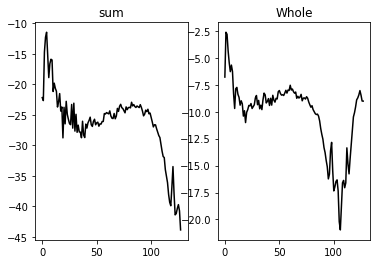

In [16]:
#d1 is already in 1xn dimensions, d2 needs to be added up

d2= librosa.amplitude_to_db(np.abs(librosa.stft(sample[0])), ref=np.max)
d2Mean=np.sum(d2,axis=1)
d2Mean=librosa.feature.melspectrogram(S=d2Mean, sr=sr,n_fft=2000, hop_length=999,)
plt.subplot(1, 2, 1)
sns.lineplot(data=d2Mean)
plt.title('sum')
plt.subplot(1,2,2)
sns.lineplot(data=z1)
plt.title('Whole')

###  .Lets start over and get rid of MFCC and  conversion of amplitude to db

((5262,), (1025,), 2631.0)

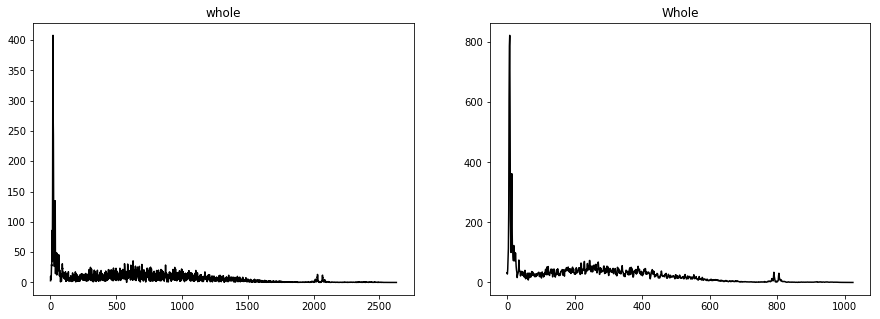

In [17]:
# d1= librosa.amplitude_to_db(np.abs(scipy.fft(sample[0])), ref=np.max)
# d2= librosa.amplitude_to_db(np.abs(librosa.stft(sample[0])), ref=np.max)
# print(d2,d1)
d1= np.abs(scipy.fft(sample[0]))
d2= np.sum(np.abs(librosa.stft(sample[0])),axis=1)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.lineplot(data=d1[0:int(len(sample[0])/2)])
plt.title('whole')
plt.subplot(1,2,2)
sns.lineplot(data=d2)
plt.title('Whole')

d1.shape,d2.shape,len(sample[0])/2

#### Some examples of windowing 

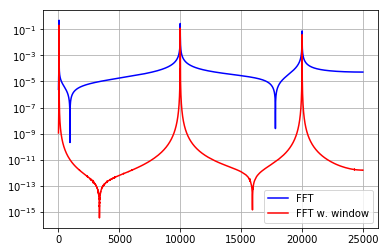

In [107]:
from scipy.fftpack import fft
# Number of sample points
N = 20000
# sample spacing
T = 1.0 / 50000.0
x = np.linspace(0.0, N*T, N)
y = 0.5*np.sin(50.0 * 2.0*np.pi*x) + 0.1*np.sin(120000.0 * 2.0*np.pi*x) + 0.3*np.sin(10000.0 * 2.0*np.pi*x)
yf = fft(y)
from scipy.signal import blackman
w = blackman(N)
ywf = fft(y*w)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

import matplotlib.pyplot as plt
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(ywf[1:N//2]), '-r')
plt.legend(['FFT', 'FFT w. window'])
plt.grid()
plt.show()

9009.512278553384
2015.607137199622
0.5013556122358894


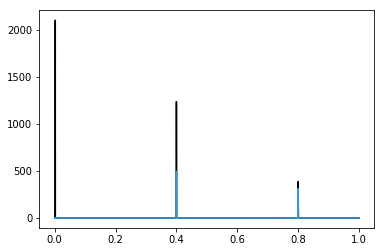

In [109]:
#applying a high shelf

amplitudes=np.abs(ywf[0:N//2])
highShelf=np.linspace(0,1,N//2)
highShelf=highShelf
filtered_amps=amplitudes*highShelf

import seaborn as sns
ax=sns.lineplot(x=np.linspace(0,1,amplitudes.shape[0]),y=amplitudes)
ax=sns.lineplot(x=np.linspace(0,1,amplitudes.shape[0]),y=filtered_amps)

def highFreqs(y,sr=sr):
    N = y.shape[0]
    w = blackman(N)
    ywf = fft(y*w)
    amplitudes=np.abs(ywf[1:N//2])
    highShelf=np.linspace(0,1,(N//2)-1)
    highShelf=highShelf**10
    filtered_amps=amplitudes*highShelf
    sum=np.sum(filtered_amps)/N
    return 1.00/(1.000+np.exp(-1*sum))

print(np.sum(amplitudes))
print(np.sum(filtered_amps))
print(highFreqs(y))